In [1]:
from numpy import *
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import grating_casimir.grating_casimir as gcas
from grating_casimir.materials import ideal, gold, Rb87, Rb87_simple
from grating_casimir.const import *

In [3]:
%matplotlib nbagg

In [4]:
def USpecAnalysis(u_spec_, xi_, mode='t', tmin=0, tmax=1):
    """
    In t mode, show the integrand(t), t = xi/(1+xi) \in [0,1] by default
    In xi mode, show the integrand(xi), xi \in [0,+\infty) by default
    """
    if mode == 't':
        amin, amax = (tmin,tmax)
        a_ = xi_/(1+xi_)
    elif mode == 'xi':
        amin, amax = (tmin/(1-tmin), np.inf if tmax==1 else tmax/(1-tmax))
        a_ = xi_
    else:
        raise ValueError("Only Two options for `mode`: 't' or 'xi'. ")
    idx_ = np.logical_and(a_>=amin, a_<=amax)
    a_ = a_[idx_]
    u_spec_ = u_spec_[idx_]
    idx_ = np.argsort(a_)
    a_ = a_[idx_]
    u_spec_ = u_spec_[idx_]
    print("#Xi =", a_.size)
    if mode == 't':
        jac_ = ((1-a_)**(-2)).reshape(-1,1)
        u_spec_ *= jac_
    plt.plot(a_, u_spec_)
    plt.ylabel("Integrand (neV)")
    if mode == 't':
        plt.xlabel(r"$t = \frac{\xi/\omega_0}{1+\xi/\omega_0}$")
    else:
        plt.xlabel(r"$\xi/\omega_0$")
        plt.xscale('log')
    plt.subplots_adjust(left=0.16,right=0.99, top=0.99)
    return a_, u_spec_

## Px=2, a=1, Y=10
<img src="Px2_A1_X2_Y10/5612.png" width=600 />

In [5]:
outs = {}
for msh in [2693, 5612]:
    outs[msh] = loadtxt("Px2_A1_X2_Y10/1DPEC_%d.out"%msh)[:,[0,-1]]

<IPython.core.display.Javascript object>


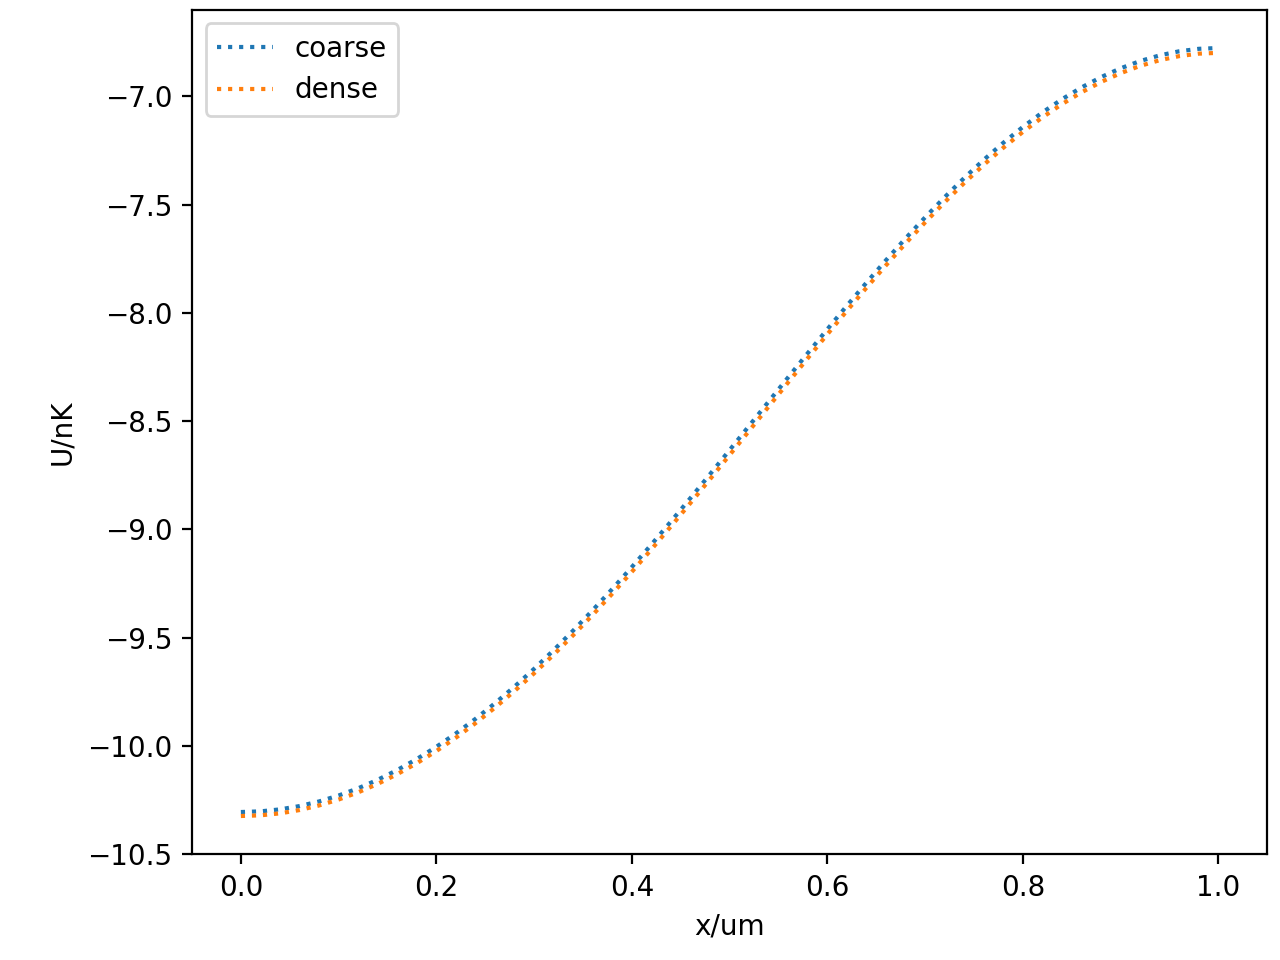

In [9]:
for msh, arr in outs.items():
    plt.plot(arr[:,0], arr[:,1]*e_charge/k_B, ":", label="dense" if msh>3500 else "coarse")
plt.xlabel("x/um")
plt.ylabel("U/nK")
plt.legend()
plt.subplots_adjust(right=0.99, top=0.99, left=0.15)

Compare with outcome from Fan's code

In [7]:
# physical parameters
d = 2e-6  # periodicity
z_A = 1e-6  # distance
a = 1e-6   # groove depth
xi = 3e14  # rad/s

# convergence parameters
n_x = 21
n_y = 41
n_order = 11
n_order_modes = int(ceil(min(n_order, 1+10/(2*pi/d*z_A))))

x_A = linspace(0, d*0.5, 21)

In [8]:
u_xscan = gcas.u_cp(Rb87, ideal, d, d/2, a, x_A, [z_A]*len(x_A), n_x, n_y, n_order, n_order_modes, 31, emax=10, tq=True)

100%|██████████| 31/31 [01:55<00:00,  3.73s/it]


<IPython.core.display.Javascript object>


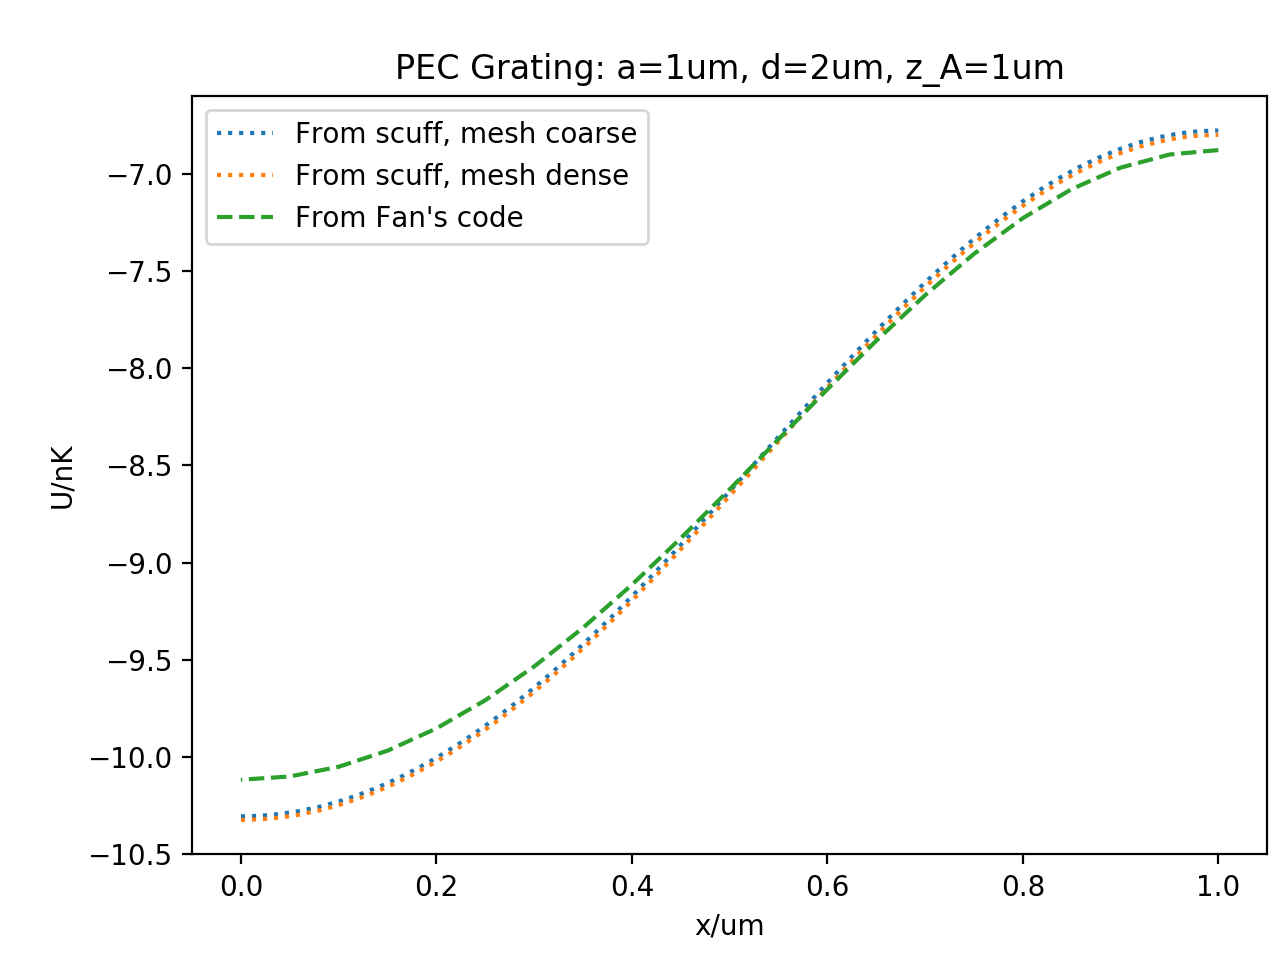

In [10]:
for msh, arr in outs.items():
    plt.plot(arr[:,0], arr[:,1]*e_charge/k_B, ":", label="From scuff, mesh "+("dense" if msh>3500 else "coarse"))
u_xscan = array(u_xscan)
plt.plot((1.0-x_A*1e6), u_xscan/(1e-9*k_B), "--", label="From Fan's code")
plt.xlabel("x/um")
plt.ylabel("U/nK")
plt.title("PEC Grating: a=1um, d=2um, z_A=1um")
plt.subplots_adjust(right=0.99, top=0.9, left=0.15)

plt.legend()

I manually horizontally flipped the outcome from Fan's code because of the different conventions in groove and plateau: x=0 is a plateau in mine but a groove in Fan's. 

Even so, there is some discrepancy, which should **NOT** result from the open boundary condition in Y direction because the variation is larger than what the scattering method (what Fan's code is based on) implies.

Take a look at the imaginary frequency $\xi$ spectrum to confirm that, the discrepancy results only from numerical methods instead of physical errors.

### $\xi$ spectrum comparison

In [11]:
arr = loadtxt("Px2_A1_X2_Y10/1DPEC_2693.byXi")

xx_ = arr[:51,0]

xi_ = arr[::51,3]

u_spec_ = arr[:,-1].reshape(-1,51)

#Xi = 16


<IPython.core.display.Javascript object>


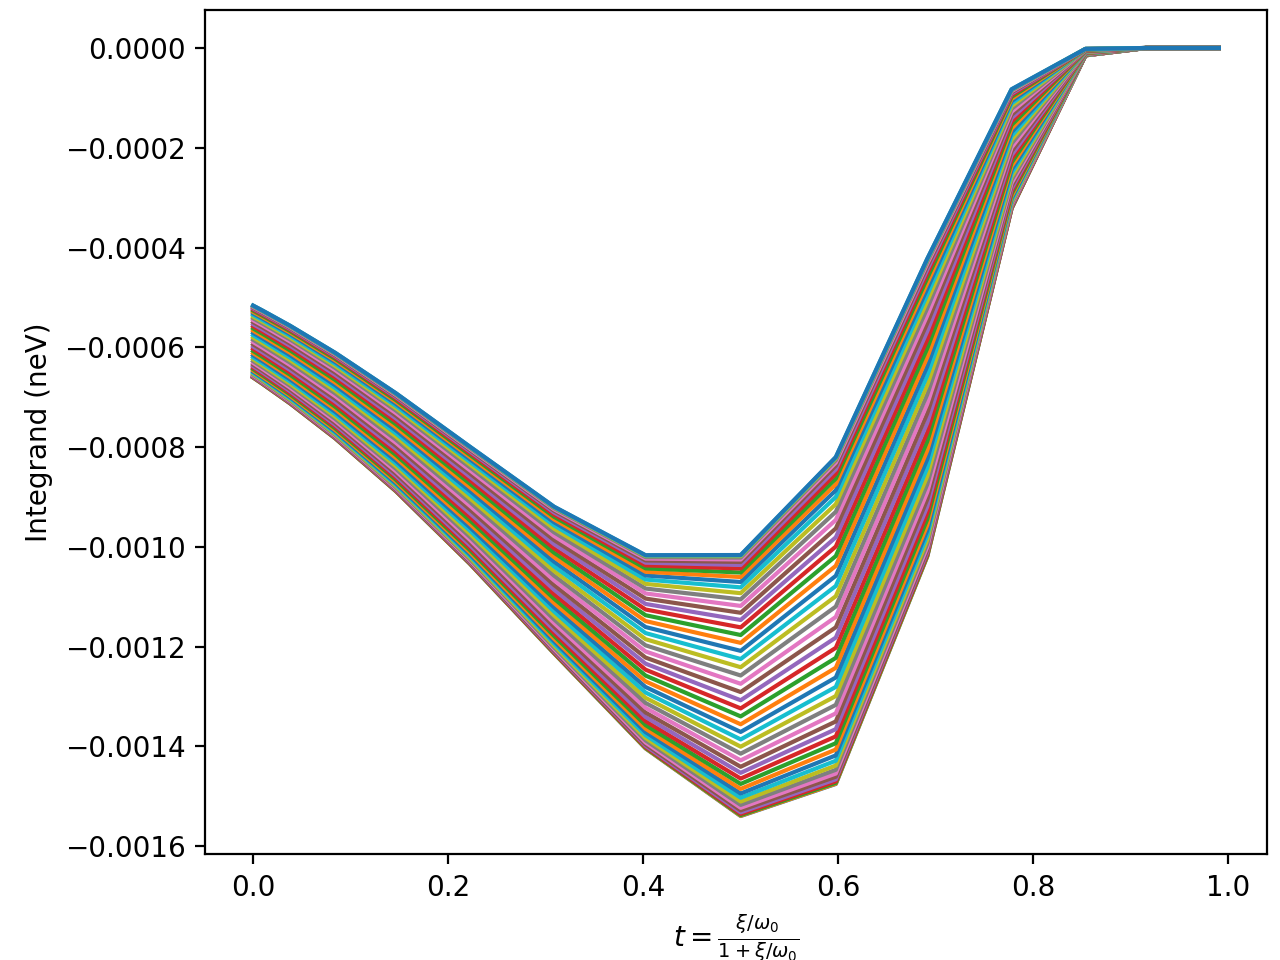

In [12]:
ti_, u_spec_t = USpecAnalysis(u_spec_, xi_)

Different traces corresponds to different $x_A$, from 0 to 1um

#### From Fan's code

In [13]:
xispec_prefac = 1 / (2*np.pi) * hbar/epsilon_0/c**2 / e_charge * 3e14 * 1e9

In [14]:
integrands_ = []
for xixi in xi_:
    xi = xixi*3e14
    integrands_.append(gcas.integrand2(ideal.epsilon, Rb87.polarizability, d, d/2, xi, a, 
                            x_A, [z_A]*len(x_A), n_order, n_order_modes, n_x, n_y, k_y_max=3))
integrands_ = np.array(integrands_)*xispec_prefac

#Xi = 16


<IPython.core.display.Javascript object>


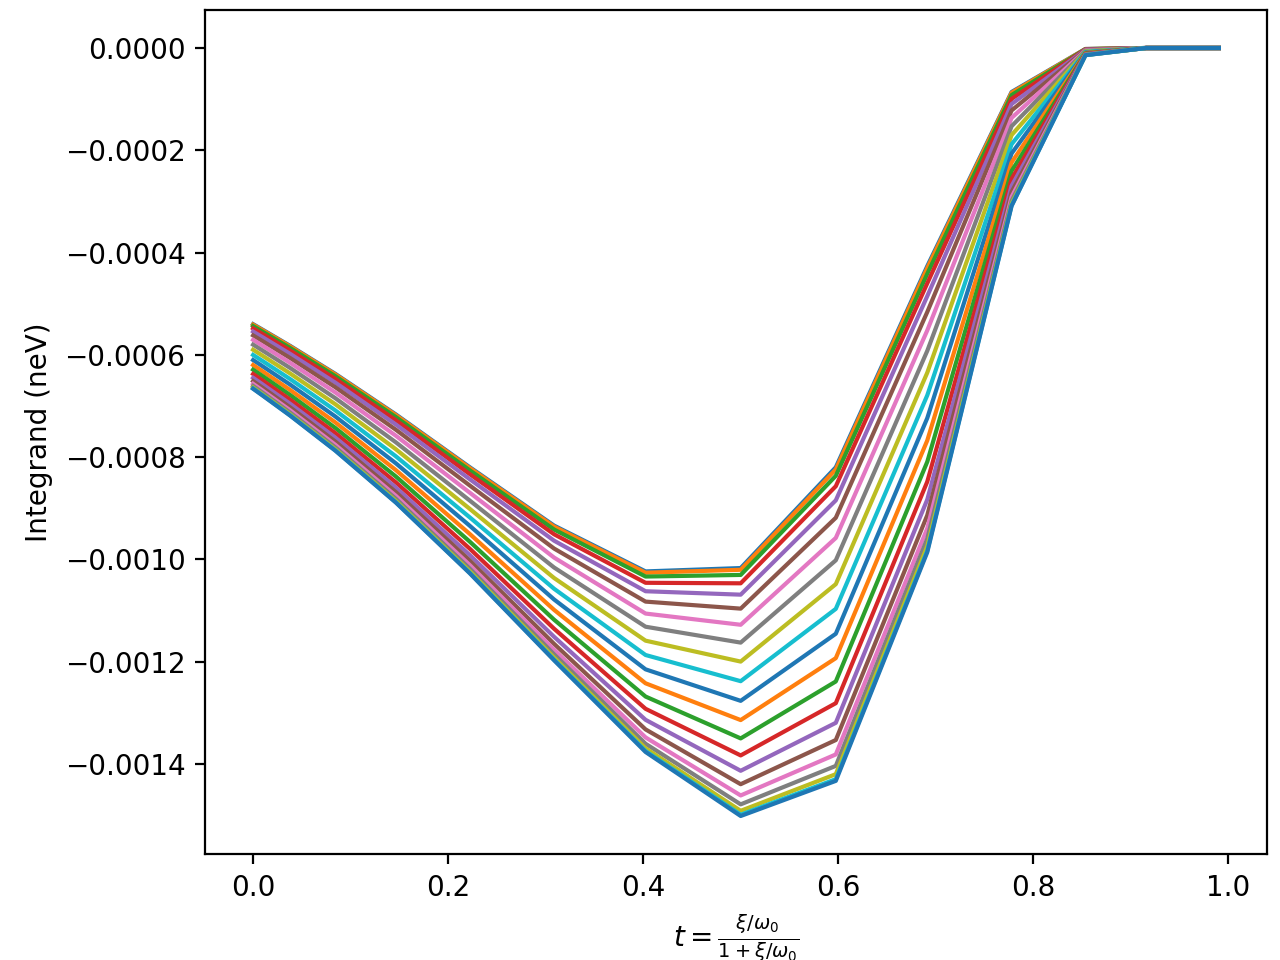

In [17]:
ti_, integrands_t = USpecAnalysis(integrands_, xi_)

<IPython.core.display.Javascript object>


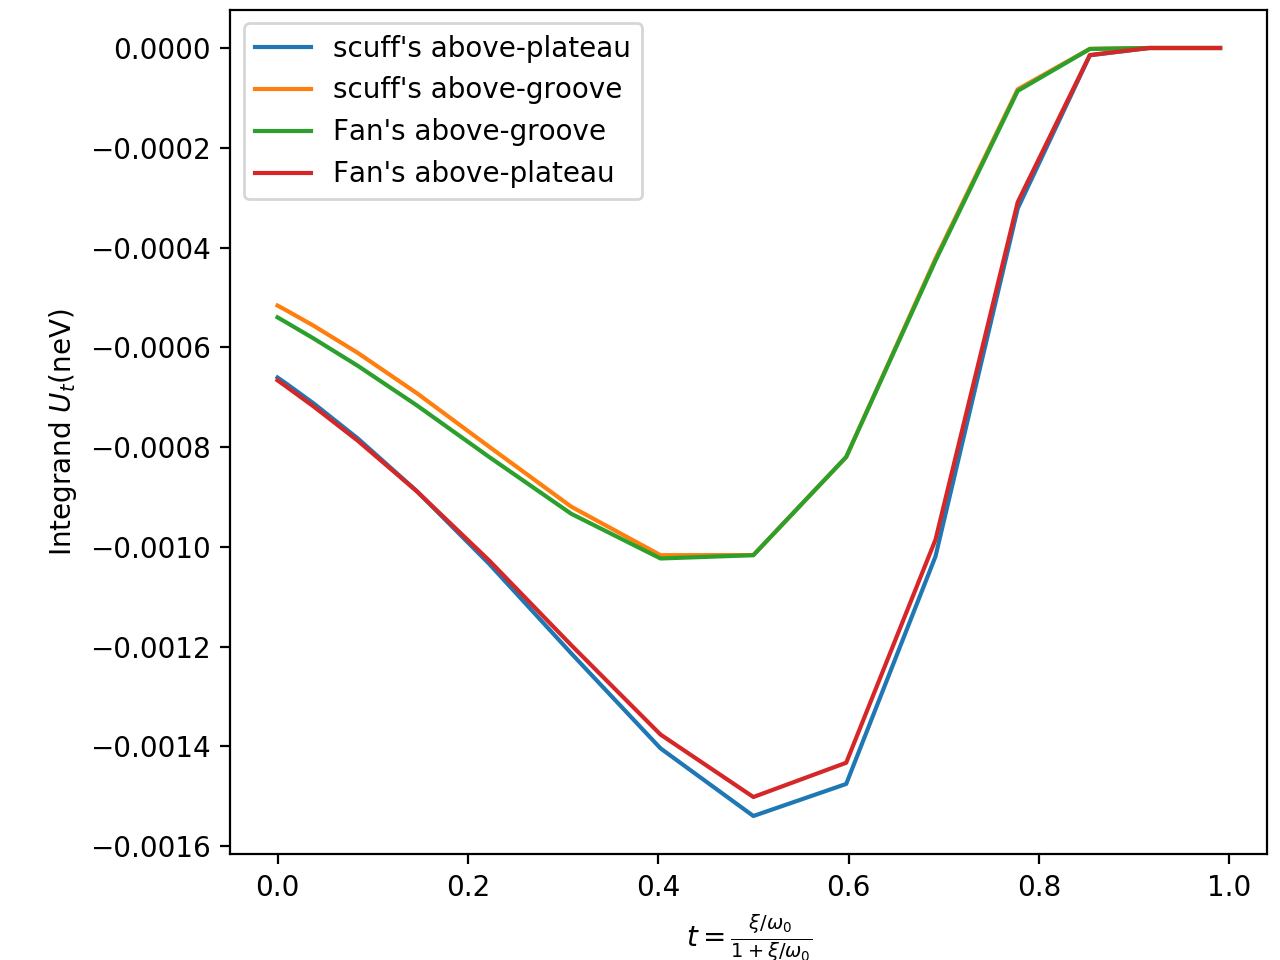

In [18]:
lns = plt.plot(ti_, u_spec_t[:,[0,-1]])
lnf = plt.plot(ti_, integrands_t[:,[0,-1]])
plt.xlabel(r'$t=\frac{\xi/\omega_0}{1+\xi/\omega_0}$')
plt.ylabel(r"Integrand $U_t$(neV)")
plt.legend(lns+lnf, ["scuff's above-plateau","scuff's above-groove","Fan's above-groove","Fan's above-plateau"])
plt.subplots_adjust(left=0.18,right=0.99, top=0.99)